In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
import dlib
%matplotlib inline

In [2]:
def get_landmarks(img):
    """Single face landmark detector. return an nparray."""
    rects = detector(img, 1)
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])

In [3]:
def extract_eyes_by_dlib(img, pad_scale=0.4, resize_width=50, resize_height=30, combine=False):
    # get facial landmark matrix by dlib
    mat = get_landmarks(img)
    
    left_left = mat[36,0]
    left_right = mat[39,0]
    left_top = min(mat[37,1], mat[38,1])
    left_bottom = max(mat[40,1], mat[41,1])
    right_left = mat[42,0]
    right_right = mat[45,0]
    right_top = min(mat[43,1], mat[44,1])
    right_bottom = max(mat[46,1], mat[47,1])
    # left pad
    left_pad_width = int((left_right - left_left) * pad_scale)
    left_pad_height = int((left_bottom - left_top) * pad_scale)
    # right pad
    right_pad_width = int((right_right - right_left) * pad_scale)
    right_pad_height = int((right_bottom - right_top) * pad_scale)
    # left and right eye plus pads
    left_eye = img[left_top-left_pad_height : left_bottom+left_pad_height, left_left-left_pad_width : left_right+left_pad_width]
    right_eye = img[right_top-right_pad_height : right_bottom+right_pad_height, right_left-right_pad_width : right_right+right_pad_width]
    # resize
    left_eye = cv2.resize(left_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    right_eye = cv2.resize(right_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    if combine:
        return np.concatenate((left_eye, right_eye), axis=1)    
    return left_eye, right_eye

In [4]:
def pre_process(img, img_width=640, img_height=480, out_width=50, out_height=30):
    """Input a raw image, process to a certain format to throw into CNN."""
    """Return combined, equalized eyes with size (30, 100, 1)."""
    # gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # if the input image is not (640x480), resize to this shape.
    if gray.shape != (img_height, img_width):
        gray = cv2.resize(gray,(img_width, img_height),interpolation=cv2.INTER_CUBIC)
    # Do a Histogram Equalization 
    equ = cv2.equalizeHist(gray)
    # extract eyes by dlib and concatenate left and right eye images.
    eyes_img = extract_eyes_by_dlib(equ, pad_scale=0.4, resize_width=out_width, resize_height=out_height, combine=True)
    print(eyes_img.shape)
    # eyes_img.shape = (30, 100, 1)
    return eyes_img.reshape(out_height, out_width*2, 1)
    
    

In [5]:
def predict(processed_img):
    """Pridict the glance direction of the input eyes image with the trained model, 
    return the predict label as a integer."""
    sess = tf.get_default_session()    
    prediction = sess.run(predict_operation, feed_dict={x: processed_img})
    return prediction
    

In [6]:
def write_result(original_img, pred):
    """write the predict result on the raw image."""
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Classification result: ' + LABEL_MAP[pred]
    cv2.putText(new_img, text, (40,70), font, 1, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [7]:
def process_image(img):
     """Input a raw image, do a glance classification, write result on this image."""
    processed_img = pre_process(img)
    
    pred = predict(processed_img)
    
    res_img = write_result(img, pred)
    
    return res_img
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

(30, 100)
(480, 640, 3)


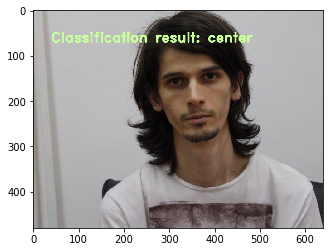

In [11]:
# Pre-process 
predictor_path = "shape_predictor_68_face_landmarks.dat/data"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
LABEL_MAP = {0: "center", 1: "top left", 2: "top left", 3: "left", 4: "right", 5: "bottom left", 6: "bottom right"}

# predict
# predict_operation = tf.argmax(logits, 1)

# meta_path = "./trained_model/model.ckpt.meta"
# model_path = './trained_model/model.ckpt'
# saver = tf.train.import_meta_graph(meta_path)      # import graph
# with tf.Session as sess:
#     saver.restore(sess, model_path)
#     graph = tf.get_default_graph()
#     prediction = predict(X_new_nor)
    


example_img = io.imread("./data/Eye_chimeraToPublish/0/eyes003019.jpg")
eyes_img = pre_process(example_img)
write_img = write_result(example_img, 0)
print(write_img.shape)


plt.imshow(write_img)
plt.savefig('wrote_label')

(30, 100)


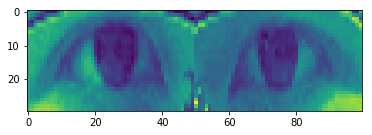

In [17]:
example_img = io.imread("./data/columbia_gaze_data_set/Columbia Gaze Data Set/0001/0001_2m_0P_0V_0H.jpg")
processed_img = pre_process(example_img)
plt.imshow(processed_img.squeeze())